In [2]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

A Simple Demonstration of Coregionalization
--

*James Hensman 2016, 2017*

In this notebook I'll demonstrate how to fit a simple model with two correlated outputs. For a little added complexity, the noise on the observations will have a heavy tail, so that there are outliers in the data.  

In GPflow, multiple output models are specified by adding an extra _input_ dimension. We'll augment the training data X with an extra column contining 1 or 0 to indicate which output an observation is associated with. This also works at prediction time: you have to specify two columns containing the location and the output of the prediction. 

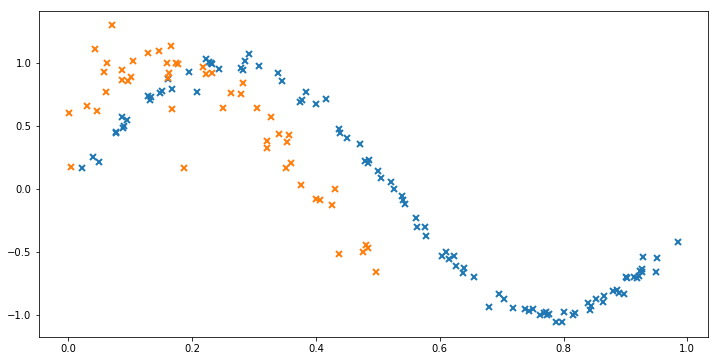

In [3]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)
X2 = np.random.rand(50, 1) * 0.5
Y1 = np.sin(6*X1) + np.random.standard_t(3, X1.shape)*0.03
Y2 = np.sin(6*X2+ 0.7) + np.random.standard_t(3, X2.shape)*0.1

plt.plot(X1, Y1, 'x', mew=2)
plt.plot(X2, Y2, 'x', mew=2)


To build a GP with correlated multiple outputs, we'll use a kernel of the form

$$\textrm{cov}(f_i(x), f_j(y)) = k_1(x, y) \times B[i, j]$$

The covariance of the i'th function at x and the j'th function at y is a kernel applied at x and y, times the i, j'th entry of a positive definite matrix B. This is known as the _intrinsic model of coregionalization_.

To make sure that B is positive-definite, we parameterize is as

$$B = W W^\top + \textrm{diag}(\kappa)$$. These parameters will be formed by the Coregion kernel below.

In [4]:
# a Coregionalization kernel. The base kernel is Matern, and acts on the first ([0]) data dimension.
# the 'Coregion' kernel indexes the outputs, and actos on the second ([1]) data dimension
k1 = gpflow.kernels.Matern32(1, active_dims=[0])
coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
kern = k1 * coreg

# build a variational model. This likelihood switches between Student-T noise with different variances:
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])

# Augment the time data with ones or zeros to indicate the required output dimension
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))

# Augment the Y data to indicate which likeloihood we should use
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y2, np.ones_like(X2)))))

# now buld the GP model as normal
m = gpflow.models.VGP(X_augmented, Y_augmented, kern=kern, likelihood=lik, num_latent=1)

In [5]:
# fit the covariance function parameters
m.compile()
gpflow.train.ScipyOptimizer().minimize(m)

/Users/Artem/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -149.235427
  Number of iterations: 737
  Number of functions evaluations: 789


That's it: the model has trained. Let's plot the model fit to see what's happened.

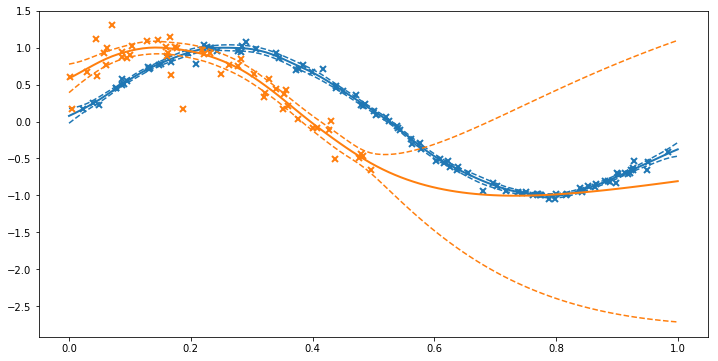

In [6]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)

def plot(m):
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(X1, Y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

    line, = plt.plot(X2, Y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color())

plot(m)

From the plots we see:

 - The first function (blue) has low posterior variance everywhere because there are so many observations, and the noise variance is small. 
 - The second function (orange) has higher posterior variance near the data, because the data are more noisy, and very high posterior variance where there are no observations (x > 0.5). 
 - The model has done a reasonable job of estimating the noise variance and lengthscales.
 - The model has done a poor job of estimating the correlation between functions: at x>0.5, the upturn of the blue function is not reflected in the orange function.
 
To see why this is the case, we'll inspect the parameters of the kernel:

In [8]:
m.kern.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/matern32/variance,Parameter,None,+ve,True,(),True,1.070109493979352
VGP/kern/matern32/lengthscales,Parameter,None,+ve,True,(),True,0.5657415107979085
VGP/kern/coregion/W,Parameter,None,(none),True,"(2, 1)",True,"[[0.0], [0.0]]"
VGP/kern/coregion/kappa,Parameter,None,+ve,True,"(2,)",True,"[0.689203531496, 1.30898616407]"


We see that the W matrix has entries of zero. This is a caused by a saddle point in the objective: re-initializing the matrix to random entries should give a better result.

In [9]:
m.kern.coregion.W = np.random.randn(2, 1)

In [10]:
gpflow.train.ScipyOptimizer().minimize(m)

/Users/Artem/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -152.066497
  Number of iterations: 1001
  Number of functions evaluations: 1081


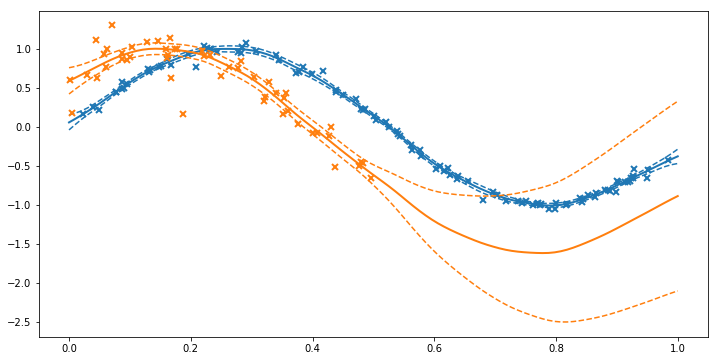

In [11]:
plot(m)

The plot is much more satisfying. The model now recognises the correlation between the two functions and is able to suggest (with uncertainty) that as x > 0.5 the orange curve should follow the blue curve (which we know to be the truth from the data generating procedure above). 